In [1]:
import src.fetch as fetch
import src.process as process
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LassoCV, RidgeCV, RidgeClassifierCV, SGDClassifier



In [2]:
client = fetch.client("credentials.json")

query = fetch.FULL_QUERY

In [3]:
data = fetch.fetch_data(client, query)
data.head()

,Q001,Q006,nota_final,pop,pib_pc,cv_polio,hcsap,macsap,mi5,subnutricao,...,ga19,ppau,ti,pgcm,pnpcm,vci,vcn,vcm,ees,mees
0,H,G,2654.0,95832,44304.781657,89.245283,1057.244276,206.701719,17.681729,4.198653,...,13.490504,1.911055,0.699937,0.454416,0.900853,254.668930,86.380651,260.957117,58.881551,77.380565
1,C,C,2592.9,7788,28530.854186,50.537634,216.543958,60.733767,24.691358,5.790501,...,9.876543,0.000000,0.000000,0.232117,0.799323,0.000000,138.312586,53.648069,38.346910,61.443299
2,E,H,3092.5,12627,25261.954407,74.248927,467.411062,164.213754,13.761468,4.608661,...,16.055046,2.382872,2.129194,0.691360,0.781631,24.390244,31.446541,213.534823,38.424459,56.554524
3,B,B,2366.0,5351,44879.911717,81.250000,2348.529702,158.685738,22.017030,4.317789,...,15.625000,5.112426,0.000000,0.449230,0.742219,0.000000,57.971014,151.114469,42.963371,62.500000
4,E,G,2503.2,95832,44304.781657,89.245283,1057.244276,206.701719,17.681729,4.198653,...,13.490504,1.911055,0.699937,0.454416,0.900853,254.668930,86.380651,260.957117,58.881551,77.380565


In [4]:
data.shape

(721426, 57)

In [5]:
reg_models_to_test = {
        'RandomForest': RandomForestRegressor(random_state=42),
        'GradientBoosting': GradientBoostingRegressor(random_state=42),
        'LASSO': LassoCV(cv=5, random_state=42),
        'Ridge': RidgeCV(cv=5)
    }

clf_models_to_test = {
        'RandomForest': RandomForestClassifier(random_state=42),
        # 'GradientBoosting': GradientBoostingClassifier(random_state=42),
        # 'SGD + L1': SGDClassifier(loss='log_loss', penalty='l1', alpha=0.01),
        # 'Ridge': RidgeClassifierCV(cv=5)
    }

In [7]:
df_unified = data.copy()

# Calcular a diferença em relação à média da faixa de renda
df_unified['nota_diff'] = df_unified['nota_final'] - df_unified.groupby('Q006')['nota_final'].transform('mean')

# Transformar em variável binária
# 1 = desempenho acima da média para a faixa de renda
# 0 = desempenho abaixo da média para a faixa de renda
df_unified['above_average'] = (df_unified['nota_diff'] > 0).astype(int)

# Converter Q006 para variáveis dummy
df_unified = pd.get_dummies(df_unified, columns=['Q006'], prefix='renda')
df_unified = pd.get_dummies(df_unified, columns=['Q001'], prefix='escolaridade_dos_pais')

# Definir features e target
X = df_unified.drop(columns=["nota_final", "nota_diff", "above_average"])
y = df_unified["nota_diff"]
y_clf = df_unified["above_average"]

In [8]:
clf_models = process.run(X, y_clf, clf_models_to_test)


RANDOMFOREST: CV mean R²: 0.5747 ± 0.0013



ValueError: cannot set WRITEABLE flag to True of this array

In [8]:
clf_models

[{'status': 'trained',
  'message': 'Model trained successfully',
  'data': {'model_name': 'RandomForest',
   'model': RandomForestClassifier(random_state=42),
   'cv_test_score_mean': 0.6223679668622714,
   'cv_test_score_std': 0.003291005219875466,
   'train_score': 1.0,
   'test_score': 0.6298078819677305}}]

In [14]:
rf = clf_models[0]['data']['model']



In [22]:
features_df = pd.DataFrame(list(zip(X.columns, rf.feature_importances_)))
features_df.head()

,0,1
0,pop,0.014438
1,pib_pc,0.006629
2,cv_polio,0.005357
3,hcsap,0.006116
4,macsap,0.006606


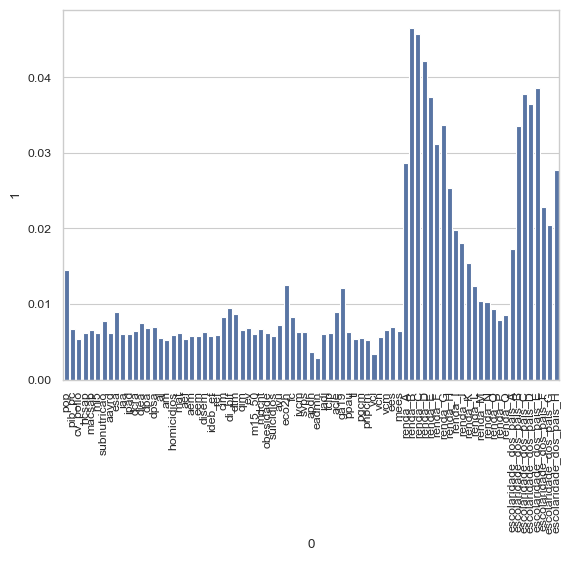

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="paper", style="whitegrid")

sns.barplot(data=features_df, x=0, y=1)
plt.xticks(rotation=90)
plt.show()